# Sensitivity Analysis: Morris Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In this notebook, we will implement Morris Method of Elementary Effects, which is used as a sensitivity analysis method to screen input factors of a model for importance. It varies each factor one at a time and evaluates how the model output changes.

The explanation and implementation was based on

 ## Morris Method: a brief introduction

The method of elementary effects was originally proposed by Morris to identify input factors of a model whose effects could be considered to be (1) negligible, (2) linear and additive, or (3) non-linear / due to interactions with other factors.

Briefly, elementary effects for a model with k input factors are obtained by varying each factor in a discretized input space, in a form of a grid $\Omega$ with pre-defined number of levels p. Then, the elementary effect of the i-th input factor, given a specific point in the p-level grid, is defined as: 

$$  EE_i=  \frac{[Y(X_1,X_2,…,X_{i-1},X_i+\Delta,…X_k )-Y(X_1,X_2,…,X_{i-1},X_i,…X_k )]}{\Delta}$$

where $\Delta$ is a value in $\left \{1/(p-1), ..., 1-1/(p-1)\right \} $, $X$ are selected values in grid-space $\Omega$ and $Y(X)$ is model evaluation on a given point.

## Sampling method

One of the key challenges in Morris' Elementary Effects method is: how can we create sample trajectories so that the input space is well-explored in an efficient way? In his original design, Morris suggested a method that creates r trajectories consisting of (k+1) points from the input space. Each trajectory can be used to calculate k elementary effects, one for each input factor. This section explains how we can obtain a set of these trajectories that allows for efficient evaluation of elementary effects.

### Choice of _p_ and ${\Delta}$

Choice of parameters _p_ and ${\Delta}$ are a critical part of the implementation of Morris method. 

Generally, an even value is recommended as the choice for p, as this simplifies the choice of ${\Delta}$. Assuming that p is equal, the delta is then chosen to be:

$$ {\Delta} = \frac{p}{2(p-1)}$$

According to Morris, this choice of ${\Delta}$ ensures that there is an equal probability of sampling from each level of the grid. Below is an implementation of the function to get delta:

In [2]:
def get_delta(num_levels):
    """
    Function for obtaining delta for Morris method.
    
    Parameters:
        num_levels - number of levels (p) of the input grid space.
    
    Returns:
        delta - increment to be used when obtaining elementary effects
    """
    delta = num_levels/(2*(num_levels-1))
    return delta

### x*

Each trajectory begins with a base vector (denoted as **x***) that is randomly selected from a p-level grid ${\Omega}$. The x* must be chosen in such a way so that after increasing one or more of the x* factors by ${\Delta}$ the point still lies within the input space.

In this implementation the grid from which we sample x* has boundaries of 0 and $(1 - {\Delta})$. The number of availaible points is chosen to be $p / 2$, which is a recommended choice.

In [3]:
def get_x_star(num_levels, num_input, delta):
    """
    Function for obtaining delta for Morris method.
    
    Parameters:
        num_levels - number of levels (p) of the input grid space.
        num_input - number of input factors of the model
        delta - increment to be used when obtaining elementary effects
    
    Returns:
        x_star - basis vector / starting for the Morris trajectories
    """
    grid = np.linspace(0, 1-delta, int(num_levels/2))
    x_star = np.random.choice(grid, size=num_input)
    return x_star

### Trajectories

The idea behind the algorithm for generating a sampling trajectory is very simple: for a starting point (x*), a random factor is selected and this factor is incremented by $\pm{\Delta}$, generating a new point. This process is repeated until all factors have been moved once by ${\Delta}$.

A trajectory can be easily computed by considering it in a form of a matrix **B*** with dimensions of (k+1) x k, where each row is a point obtained by moving one factor of the model by ${\Delta}$. To construct **B***, we first choose a strictly lower triangular matrix of 1's, **B**, with dimensions of (k+1)x(k). This ensures that only one input factor is changed at a time, as for every column index j, there are two rows that only differ in the jth entry.

The sampling matrix is then given by:

$$ B' = J_{k+1,k}x^* + {\Delta}B$$
    
where $J_{k+1,k}$ allows to create k+1 copies of the starting point $x^*$ of trajectory


A randomized version of this matrix is given by: 
$$ B^* = (J_{k+1,1}x^* + ({\Delta}/2)\left[(2B-J_{k+1,k})D^*+J_{k+1,k}\right])P^* $$

$J_{k+1,1}x^*$ : creates k+1 copies of point x*

$D^*$: determines whether factors move by $+{\Delta}$ or $-{\Delta}$

$P^*$ : a k-by-k random permutation matrix in which each row contains an element equal to 1 with all other elements equal to 0. As no two columns have 1s in the same position, this matrix determines the order in which the factors move.



In [4]:
def compute_Bstar(num_input, delta, x_star):
    """
    Function for obtaining a sample trajectory in form of B*.
    
    Parameters:
        num_input - number of input factors of the model
        delta - increment to be used when obtaining elementary effects
        x_star - starting points for the Morris trajectories
    
    Returns:
        B_star - a sample trajectory for Morris method.
    """
    k = num_input
    
    B = np.tril(np.ones((k+1, k)), -1) # Obtain strictly lower triangular matrix
    
    # Obtain matrices J
    J_copy = np.ones((k+1,1))
    J = np.ones((k+1, k))
    
    # Obtain matrix D*
    D_star = np.diag(np.random.choice([-1,1],size=k))
    
    # Obtain permutation matrix P*
    P_star = np.eye(k,k)
    P_star = np.random.permutation(P_star)
    
    
    # Computation of B* is divided into three parts
    part_a = ((np.matmul(2*B-J,D_star) + J)*delta/2)
    part_b = part_a + J_copy*x_star
    B_star = np.matmul(part_b, P_star)
    return B_star

We then repeat the process for the desired number of trajectories, generating our final Morris sample:

In [5]:
def morris_sample(num_input, n_trajectories, num_levels):
    """
    Function for generating sample trajectories for Morris method of Elementary Effects.
    
    Parameters:
        num_input - number of input factors of the model
        n_trajectories - number of trajectories to be calculated
        num_levels - number of levels in the grid space
    
    Returns:
        B_star - a sample trajectory for Morris method.
    """
    k = num_input
    
    delta = get_delta(num_levels)
    
    morris_sample = np.zeros([n_trajectories,k+1,k])
    
    for i in range(n_trajectories):
        x_star = get_x_star(num_levels, k, delta)
        
        morris_sample[i, :,:] = compute_Bstar(k, delta, x_star)
        
    return morris_sample

## Elementary Effects

Now that we have obtained our sample trajectories, majority of the hard work is done - we just need to evaluate our model on the sampled points and calculate the elementary effects. To recap, the elementary effect is defined as:

$$  EE_i=  \frac{[Y(X_1,X_2,…,X_{i-1},X_i+\Delta,…X_k )-Y(X_1,X_2,…,X_{i-1},X_i,…X_k )]}{\Delta}$$



Of course, looking at potentially 100s or 1000s elementary effects for each factor is probably not very informative. Morris thus proposed two sensitivity measures that can inform as about the effect of each factor.

The estimate of the **mean** of distribution of the elementary effects for each factor, ${\mu}$ , assesses the overall influence of the factor on the output of the model:
$${\mu_i} = \frac{1}{r}\sum_{j=1}^{r}EE_i^j$$
where $r$ is the number of trajectories.

The **standard deviation** of elementary effects of each factor, ${\sigma^2}$, estimates factor's nonlinear or interaction effect:
$${\sigma_i^2} = \frac{1}{r-1}\sum_{j=1}^{r}(EE_i^j-{\mu})$$

As sometimes the elementary effects might cancel each other out, decreasing the mean, Campologno et al. (2007) proposed an additional sensitivity measure - ${\mu^*}$, an estimate of the mean of distribution of the absolute elementary effects.
$${\mu_i} = \frac{1}{r}\sum_{j=1}^{r}\left |{EE_i^j}\right |$$

Below is my implementation of the elementary effects method. It calculates and returns all three sensitivity metrics:

In [6]:
def elementary_effects(sample, model, delta):
    """
    Function for calculating Elementary Effects.
    
    Parameters:
        sample - sample trajectories generated via Morris method
        model - function to be used to generate outputs
        delta - increment to be used when obtaining elementary effects
    
    Returns:
        ee_mean - means of elementary effects for each factor (known as mu)
        ee_absmean - means of absolute elementary effects for each factor (known as mu_star)
        ee_std - standard deviation of elementary effects for each factor (known as sigma^2)
    """   
    y = np.zeros((sample.shape[0], sample.shape[1]))
    for i in range(sample.shape[0]):
        for j in range(sample.shape[1]):
            args = sample[i,j].tolist()
            y[i, j] = model(args)
    
    ee = np.zeros((sample.shape[0], sample.shape[2]))
    
    for i in range(sample.shape[0]):
        for j in range(sample.shape[1]-1):
            for k in range(sample.shape[2]):
                if sample[i, j+1, k] > sample[i,j,k]:
                    ee[i, k] = (y[i, j+1] - y[i,j])/delta
                elif sample[i, j+1, k] < sample[i,j,k]:
                    ee[i, k] = (y[i, j] - y[i,j+1])/delta
    
    ee_mean = [np.mean(ee[:,i]) for i in range(ee.shape[1])]
    ee_absmean = [np.mean(np.abs(ee[:,i])) for i in range(ee.shape[1])]
    ee_std = [np.std(ee[:,i]) for i in range(ee.shape[1])]
    
    return ee_mean, ee_absmean, ee_std

## Analysis of obtained results

We now have our summary statistics for elementary effects - but how do we interpret them? To show how one might perform a sensitivity analysis, we will test our implementation on a simple engineering function - Darcy's friction factor (calculated in terms of pressure loss and volumetric flow rate):
$$ f = \frac{{\pi^2}d^5{\Delta}P}{8{\rho}Q^2L}$$

where $f$ is friction factor, $d$ is diameter of the pipe, ${\Delta}P$ is pressure loss, ${\rho}$ is density of the fluid, $Q$ is volumetric flow rate and $L$ is length of the pipe.

Just by looking at the above formulae, we can expect to obtain results that suggest the diameter of the pipe is most influential, followed by volumetric flow rate.


In [7]:
def friction_factor(args):
    """
    Function for calculating Darcy's friction factor
    
    Parameters:
        args - a list of arguments to be passed to the function.
        Need to be passed in this specific order: diameter, pressure loss, density, flow rate, length
    
    Returns:
        friction_factor - Darcy's friction factor
    """ 
    friction_factor = ((np.pi**2)*(args[0]**5)*args[1])/(8*args[2]*(args[3]**2)*args[4])
    return friction_factor

We start by generating our sampling trajectory:

In [8]:
num_inputs = 5
num_trajectory = 1000
grid_level = 4

B = morris_sample(num_inputs, num_trajectory, grid_level)

We then have to scale our sampling trajectory - we assume mean values for each input factor: $$d - 0.05, \Delta P - 80, \rho - 1000, Q  - 0.003, L - 0.2$$
and 25% variation.

In [9]:
def scale_sample(sample, nom_vals, var):
    """
    Function for scaling a Morris sample for Elementary Effects. 
    Currently only supports scaling a uniform distribution.
    
    Parameters:
        sample - sample trajectories generated via Morris method
        nom_vals - nominal values to be used for scaling
        var - variation around the norminal values to be used for scaling
    
    Returns:
        sample - scaled Morris sample trajectories for elementary effects method.
    """ 
    for i in range(sample.shape[0]):
        for j in range(sample.shape[2]):
            sample[i,:,j] = sample[i,:,j]*(nom_vals[j]*(1+var)-nom_vals[j]*(1-var))+nom_vals[j]*(1-var)

    return sample

In [10]:
scaled_sample = scale_sample(B, [0.05,80,1000,0.003,0.2], 0.25)

Finally, we can calculate our sensitivity measures:

In [11]:
delta = get_delta(grid_level)
mu, mu_star, sigma = elementary_effects(scaled_sample, friction_factor, delta)

To quickly analyse our obtained sensitivity measures, we plot ${\sigma^2}$ versus ${\mu^*}$ (we can also plot ${\sigma^2}$ versus ${\mu}$ if we wanted to) :

In [12]:
def plot_ee_analysis(ee_mean, ee_std, legend, x_label):
    """
    Function for plotting sensitivity measures obtained from EE method.
    
    Parameters:
        ee_mean - mu or mu_star of elementary effects
        ee_std - sigma^2 of elementary effects
        legend - list of names of input factors
    """ 
    plt.figure(figsize=(6,5), dpi=90)
    for i in range(len(ee_mean)):
        plt.scatter(ee_mean[i], ee_std[i])
    plt.legend(legend)
    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel("${\sigma^2}$ of EEs", fontsize = 14)
    plt.grid(b=True, which='major', linewidth = 0.75, linestyle = '--')
    plt.xlim([0.01, 0.06])
    plt.ylim([0.01, 0.04])
    plt.axline([0.01, 0.01], [0.06, 0.04], color='black', linewidth = 0.75)
    

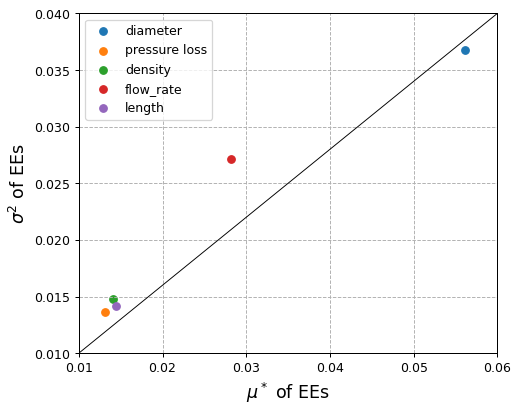

In [13]:
legend = ['diameter', 'pressure loss', 'density', 'flow_rate', 'length']
plot_ee_analysis(mu_star, sigma, legend, '${\mu^*}$ of EEs')

What can we tell from the above plot about our input factors? As expected, based on the obtained $\mu^*$, the diameter has the largest influence on the output value, followed by volumetric flow rate. Looking at $\sigma^2$, the diameter also has non-linear and/or interaction effects on the friction factor.

Of course, in practice, we would have more factors to consider - this example is just a simple model to explain the elementary effects method for sensitivity analysis. 

As EEs are quite easy to implement and quick to calculate, they are typically used as a screening method of input factors - once we have identified important factors that actually have an actual effect on model output and fixed unimportant ones, we can perform further sensitivity analysis using more computationally expensive methods, such as variance based methods.

## Comparison with available software for SA

To check if Morris method has been implemented correctly, we will compare our implementation with the method available from an open-source Python package, **SALib**, which can be found [here](https://github.com/SALib/SALib).

In [14]:
from SALib.analyze import morris
from SALib.sample.morris import sample

In [15]:
# We first need to define our problem, including number of variables & boundaries for scaling
problem = {
  'num_vars': 5,
  'names': ['diameter', 'p_difference', 'density', 'flow_rate', 'length'],
  'groups': None,
  'bounds': [[0.05*0.75, 1.25*0.05],
             [60, 100],
             [1000*0.75, 1000*1.25],
             [0.003*0.75, 0.003*1.25],
             [0.2*0.75, 0.2*1.25]]
 }

In [16]:
# We then generate a Morris sample
param_values = sample(problem, N=1000, num_levels=4,
                      optimal_trajectories=None)

In [17]:
# We evaluate the friction factor model on the generated samples
y = np.zeros(param_values.shape[0])
for i in range(param_values.shape[0]):
    args = param_values[i].tolist()
    y[i] = friction_factor(args)

In [18]:
# Finally, we obtain our sensitivity analysis metrics
Si = morris.analyze(problem, param_values, y,
                    print_to_console=True,
                    num_levels=4)

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
diameter                            0.057      0.057           0.002      0.037
p_difference                        0.013      0.013           0.001      0.013
density                             0.014     -0.014           0.001      0.015
flow_rate                           0.028     -0.028           0.001      0.028
length                              0.015     -0.015           0.001      0.016


We can see that we obtained similar values for mu_star and sigma, so our attempt at the implementation of Morris method seems to be successful.

## 3. Morris method extensions

Morris Method has a few limitations - for example, it cannot distinguish non-linear and interaction effects, or sometimes, despite a large number of model evaluations, the input parameter space is not well represented in the sample. A few methods were recently developed to improve the original Morris method: some examples include identification of optimal trajectories (included in SALib package), radial based sampling of trajectories, quasi-random sampling of parameter space. In this final section I decided to try to implement one of these extensions - an LH-OAT sampling method (a combination of latin hypercube sampling with one-at-a-time trajectory sampling allowing for efficient calculation of elementary effects), developed by van Griensven et al. (2006).

Unfortunately, I couldn't find a package implementing this method, so I didn't have time to validate my implementation. Moreover, the description of the method is brief, so I may have misinterpreted some of the steps.

### LH-OAT Method: Steps

1. 

### LH-OAT Method: Implementation

I first implement a latin hypercube sampler that samples from a uniform distribution with boundaries of (0,1). A latin hypercube sampler is implemented in SALib package and is also coming to SciPy in version 1.7

In [19]:
def lhs(factors, trajectories):
    iter_length = 1/(trajectories+1)
    x_star = np.zeros([trajectories+1, factors])
    
    for i in range(len(x_star) - 1):
        lower_bound = i*iter_length
        upper_bound = lower_bound + iter_length
        x_star[i+1,:] = lower_bound + np.random.rand(1, factors)*(upper_bound - lower_bound)
    
    x_star = x_star[1:]
    for i in range(factors):
        order = np.random.permutation(range(trajectories))
        x_star[:, i] = x_star[order, i]
    
    return x_star

Then I implement a method to calculate the elementary effects as described in van Griensven's paper. The delta is chosen to be a percentage of value of each factor, rather than pre-defined step. A key point to remember while implementing elementary effects methods is to ensure that delta is calculated **before** scaling the input factors. Delta always describes a step size in the sample space.

In LH-OAT you generally only look at the means of the obtained elementary effects and use them to rank the factors in terms of importance.

In [20]:
def lh_oat(x, model, perc, factors, trajectories, num_vals, var):
    
    partial_effects = np.empty([trajectories, factors])
    for i in range(trajectories):
        for j in range(factors):
            args = x[i].tolist()
            args1 = args.copy()
            delta = perc*args[j]
        
            if np.random.rand(1) > 0.5:
                args1[j] = delta+args[j]
    
            else:
                args1[j] = args[j]-delta
            
            args = (num_vals*(1+var)-num_vals*(1-var))*args+(num_vals*(1-var))
            args1 = (num_vals*(1+var)-num_vals*(1-var))*args1+(num_vals*(1-var)) 
            partial_effects[i,j] = np.abs(100*(model(args1)-model(args))/(0.5*(model(args1)+model(args)))/delta)

            
    pe_mean = [np.mean(partial_effects[:,i]) for i in range(factors)]
    
    temp = np.array(pe_mean).argsort()[::-1]
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(pe_mean)) + 1
    
    return pe_mean, ranks

We can test this implementation on our friction factor model to see if the same factors are identified as "important"

In [21]:
sample_lhs = lhs(5,1000);
partial_effects, ranks = lh_oat(sample_lhs, friction_factor, 0.05, 5, 1000,np.array([0.05,80,1000,0.003,0.2]), 0.25)

print('factor', 'rank')
for i in range(len(ranks)):
    print(legend[i], ranks[i])

factor rank
diameter 1
pressure loss 5
density 3
flow_rate 2
length 4


Again, diameter has been identified as the most important factor, followed by flow rate, which was expected.